## PTPRC isoform assignment specificity analysis

GENCODE v37 vs. StringTie vs. manual (decision tree)

In [154]:
# %matplotlib inline

import os
import sys
import matplotlib.pylab as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import logging
from operator import itemgetter

import scanpy as sc
import anndata
from umap import UMAP

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

logger = logging.getLogger()
logger.setLevel(logging.INFO)
log_info = logger.warning

import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.facecolor'] = 'white'

In [155]:
# load sample metadata
import yaml

with open('./downsampling_series_sample_metadata.yaml', 'r') as f:
    sample_meta_dict = yaml.safe_load(f)    

In [156]:
repo_root = '/home/jupyter/mb-ml-data-disk/MAS-seq-analysis'
long_tx_counts_root ='data/t-cell-vdj/long/quant/ds'
short_h5_path = 'output/t-cell-vdj-cite-seq/M132TS_immune.h5ad'
output_root = 'output/t-cell-vdj-cite-seq/ds'
fig_output_root = 'output/t-cell-vdj-cite-seq/ds/figures'
misc_output_root = 'output/t-cell-vdj-cite-seq/ds/misc'
output_prefix = 'M132TS_immune'

# constants
GENE_IDS_KEY = 'gencode_overlap_gene_ids'
GENE_NAMES_KEY = 'gencode_overlap_gene_names'

In [177]:
isoform_names = [
    'CD45RABC',
    'CD45RO',
    'CD45RB',
    'CD45RBC',
    'CD45RAB',
]

leiden_ids = [
    'SMC',
    'EA',
    'A IV',
    'A I',
    'A II',
    'E',
    'A III',
    'P',
]

leiden_ids_in_plot = [
    'SMC',
    'EA I',
    'A/EA',
    'EA II',
    'CE',
    'TD I',
    'TD II',
    'P',
]

## StringTie

In [178]:
sample_key = 'gencode_st2_ds_masseq'

output_prefix_full = f'{output_prefix}_{sample_key}'

final_long_adata_raw_h5_path = os.path.join(
    repo_root, output_root, f'{output_prefix_full}_final_long_raw.h5ad')

adata_long_raw = sc.read(os.path.join(repo_root, final_long_adata_raw_h5_path))
transcript_names = adata_long_raw[:, adata_long_raw.var[GENE_NAMES_KEY] == 'PTPRC'].var.index.values
transcript_ids = adata_long_raw[:, adata_long_raw.var[GENE_NAMES_KEY] == 'PTPRC'].var['de_novo_transcript_ids'].values

transcript_id_to_isoform_map = {
    'STRG.8581.7': 'CD45RBC',
    'STRG.8581.6': 'CD45RB',
    'STRG.8581.5': 'CD45RO',
    'STRG.8581.4': 'CD45RO',
    'STRG.8581.3': 'CD45RO',
    'STRG.8581.2': 'CD45RB',
    'STRG.8581.13': 'CD45RABC',
    'STRG.8581.12': 'CD45RAB',
    'STRG.8581.10': 'CD45RO',
    'STRG.8581.1': 'CD45RO'
}

quant_type = 'st2'

## GENCODE

In [183]:
sample_key = 'gencode_masseq'

output_prefix_full = f'{output_prefix}_{sample_key}'

final_long_adata_raw_h5_path = os.path.join(
    repo_root, output_root, f'{output_prefix_full}_final_long_raw.h5ad')

adata_long_raw = sc.read(os.path.join(repo_root, final_long_adata_raw_h5_path))
transcript_names = adata_long_raw[:, adata_long_raw.var[GENE_NAMES_KEY] == 'PTPRC'].var.index.values
transcript_ids = adata_long_raw[:, adata_long_raw.var[GENE_NAMES_KEY] == 'PTPRC'].var['transcript_ids'].values

transcript_id_to_isoform_map = {
    'ENST00000643513.1': 'CD45RB',
    'ENST00000530727.5': 'CD45RB',
    'ENST00000529828.5': 'CD45RAB',
    'ENST00000442510.8': 'CD45RABC',
    'ENST00000427110.6': 'CD45RB',
    'ENST00000418674.1': 'CD45RB',
    'ENST00000391970.3': 'CD45RBC',
    'ENST00000367379.6': 'CD45RO',
    'ENST00000367367.8': 'CD45RBC',
    'ENST00000348564.11': 'CD45RO'
}

quant_type = 'gencode'

## Manual

In [168]:
import os
import sys
sys.path.insert(0, '/home/jupyter/mb-ml-dev-disk/MAS-seq-analysis/sources')

from adata_utils import extend_adata

# inputs
input_prefix = 'M132TS_immune.v4.harmonized'
output_path = 'output/t-cell-vdj-cite-seq'

final_long_adata_raw_h5_path = os.path.join(repo_root, output_path, f'{input_prefix}.long.stringtie.final.raw.h5ad')

# manual isoform annotation quant
manual_adata_long_annotation_quants_path = os.path.join(repo_root, 'output/t-cell-vdj-cite-seq/manual_annotations')

adata_long_raw = sc.read(final_long_adata_raw_h5_path)

# extend adata with manual annotations
for dirname, _, filenames in os.walk(manual_adata_long_annotation_quants_path):
    for filename in filenames:
        manual_adata_long_path = os.path.join(dirname, filename)
        log_info(f'Adding manual isoform annotations from {manual_adata_long_path} ...')
        if manual_adata_long_path.split('.')[-1] != 'h5ad':
            continue
        manual_adata_long = sc.read(manual_adata_long_path)
        adata_long_raw = extend_adata(adata_long_raw, manual_adata_long)
adata_long_raw.X = adata_long_raw.X.tocsr()

transcript_names = adata_long_raw[:, adata_long_raw.var['gene_names'] == 'manual__PTPRC'].var.index.values
transcript_ids = adata_long_raw[:, adata_long_raw.var['gene_names'] == 'manual__PTPRC'].var.index.values

transcript_id_to_isoform_map = {
    'manual__PTPRC_O': 'CD45RO',
    'manual__PTPRC_B': 'CD45RB',
    'manual__PTPRC_AB': 'CD45RAB',
    'manual__PTPRC_BC': 'CD45RBC',
    'manual__PTPRC_ABC': 'CD45RABC',
}

quant_type = 'manual'

Only considering the two last: ['.raw', '.h5ad'].
Only considering the two last: ['.raw', '.h5ad'].
Adding manual isoform annotations from /home/jupyter/mb-ml-data-disk/MAS-seq-analysis/output/t-cell-vdj-cite-seq/manual_annotations/adata_long_manual__PTPRC.h5ad ...


In [184]:
isoform_name_to_isoform_idx_map = {
    isoform_name: isoform_idx
    for isoform_idx, isoform_name in enumerate(isoform_names)
}

leiden_id_to_leiden_idx_map = {
    leiden_id: leiden_idx
    for leiden_idx, leiden_id in enumerate(leiden_ids)
}

transcript_id_to_transcript_idx_map = {
    transcript_id: transcript_idx for transcript_idx, transcript_id in enumerate(transcript_ids)
}

cell_leiden_indices = np.asarray(
    list(map(leiden_id_to_leiden_idx_map.get, adata_long_raw.obs['mehrtash_leiden'].values)))

n_leiden = len(leiden_ids)
n_isoforms = len(isoform_names)
counts_li = np.zeros((n_leiden, n_isoforms))
unassigned_counts_l = np.zeros((n_leiden,))
total_counts_l = np.zeros((n_leiden,))

for leiden_idx in range(n_leiden):
    x = np.asarray(adata_long_raw[cell_leiden_indices == leiden_idx][:, transcript_names].X.sum(0)).flatten()
    unassigned = np.sum(x)
    total_counts_l[leiden_idx] = np.sum(x)
    for transcript_id, target_isoform_name in transcript_id_to_isoform_map.items():
        isoform_idx = isoform_name_to_isoform_idx_map[target_isoform_name]
        transcript_idx = transcript_id_to_transcript_idx_map[transcript_id]
        counts_li[leiden_idx, isoform_idx] += x[transcript_idx]
        unassigned -= x[transcript_idx]
    unassigned_counts_l[leiden_idx] = unassigned
    
# normalize counts
counts_li = counts_li / (1e-12 + np.sum(counts_li, -1)[:, None])
cumsum_counts_li = np.cumsum(counts_li, axis=1)
cumsum_counts_li = np.hstack((np.zeros((n_leiden, 1)), cumsum_counts_li))

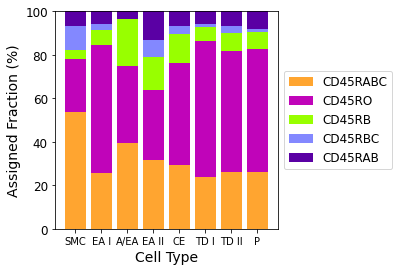

In [185]:
import colorcet as cc

fig, ax = plt.subplots(figsize=(5, 4))

isoform_colors = [
    cc.glasbey_bw_minc_20[7],
    cc.glasbey_bw_minc_20[15],
    cc.glasbey_bw_minc_20[4],
    cc.glasbey_bw_minc_20[35],
    cc.glasbey_bw_minc_20[28],
]

for isoform_idx in range(n_isoforms):
    
    try:
        label = isoform_names[isoform_idx]
    except:
        label = 'Other'
        
    ax.bar(
        np.arange(n_leiden),
        height=100. * counts_li[:, isoform_idx],
        bottom=100. * cumsum_counts_li[:, isoform_idx],
        color=isoform_colors[isoform_idx],
        label=label)
        
ax.set_ylim((0, 100.))
ax.set_xticks(np.arange(n_leiden))
ax.set_xticklabels(leiden_ids_in_plot, fontsize=10)
ax.set_ylabel('Assigned Fraction (%)')
ax.set_xlabel('Cell Type')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(f'./output/M132TS__stacked_bar__{quant_type}.pdf', bbox_inches='tight')

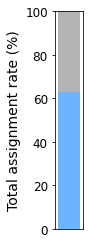

In [186]:
import colorcet as cc

fig, ax = plt.subplots(figsize=(0.5, 4))

# all queries aligning to the genome with MQ > 0
TOTAL_COUNTS = 6394
assigned_counts = np.sum(total_counts_l) - np.sum(unassigned_counts_l)
assigned_fraction = assigned_counts / TOTAL_COUNTS

assigned_color = cc.glasbey_bw_minc_20[50]
unassigned_color = (0.7, 0.7, 0.7)
        
ax.bar(
    np.arange(1),
    height=100 * assigned_fraction,
    color=assigned_color,
    label=label)

ax.bar(
    np.arange(1),
    height=100 * (1 - assigned_fraction),
    bottom=100 * assigned_fraction,
    color=unassigned_color,
    label=label)
        
ax.set_ylim((0, 100.))
ax.set_ylabel('Total assignment rate (%)')
ax.set_xticks([])
ax.set_xlim((-0.5, 0.5))

plt.savefig(f'./output/M132TS__stacked_bar__{quant_type}__assignment_rate.pdf', bbox_inches='tight')